In [ ]:
!pip install torchvision

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid  # Import make_grid from torchvision.utils
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

In [2]:
# Preprocess image function
def preprocess_image(image_path):
    # Read the image in grayscale
    tire = cv2.imread(image_path, 0)
    
    # Equalize the histogram of the grayscale image to improve its contrast
    eq_tire = cv2.equalizeHist(tire)
    
    # Apply a binary inverse threshold to the equalized image
    ret, threshold = cv2.threshold(eq_tire, 75, 255, cv2.THRESH_BINARY_INV)
    
    # Apply the Sobel operator in the x direction to the thresholded image
    sobelx2 = cv2.Sobel(threshold, cv2.CV_64F, 1, 0, ksize=7)
    
    # Apply the Sobel operator in the y direction to the thresholded image
    sobely2 = cv2.Sobel(threshold, cv2.CV_64F, 0, 1, ksize=7)
    
    # Combine the results of the Sobel operations in the x and y directions
    sobel = sobelx2 + sobely2
    
    # Blend the thresholded image and the Sobel image
    blended = threshold + sobel

    # Define the scale factor, rectangle dimensions, and top-left corner coordinates
    scale_factor = 1
    rect_width = int(1500 * scale_factor)
    rect_height = int(1333 * scale_factor)
    x1 = int(912 * scale_factor)
    y1 = int(1016 * scale_factor)
    
    # Calculate the bottom-right corner coordinates
    x2 = x1 + rect_width
    y2 = y1 + rect_height

    # Crop the blended image to the defined rectangle
    cropped_img = blended[y1:y2, x1:x2]

    # Normalize the cropped image to the range [0, 255] and convert to uint8
    cropped_img = cv2.normalize(cropped_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Return the preprocessed image
    return cropped_img


In [3]:
# Custom dataset class to apply preprocessing
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Initialize the ImageFolder dataset with the given root directory
        self.dataset = ImageFolder(root=root_dir, transform=None)
        
        # Store the transform function to be applied on the images
        self.transform = transform

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the path and label of the image at the given index
        path, label = self.dataset.samples[idx]
        
        # Preprocess the image using the function defined earlier
        image = preprocess_image(path)
        
        # Convert the grayscale image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        # Convert the OpenCV image to a PIL image
        image = Image.fromarray(image)
        
        # Apply the transform function if it is not None
        if self.transform:
            image = self.transform(image)
        
        # Return the processed image and its label
        return image, label


In [4]:
# Define the image transformation pipeline
transform = transforms.Compose([
    # Resize the image to 224x224 pixels
    transforms.Resize((224, 224)),
    
    # Convert the image to PyTorch tensor
    transforms.ToTensor(),
    
    # Normalize the image with the mean and standard deviation of the ImageNet dataset
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [5]:
# Define the path to the custom image dataset
custom_image_path = './Train'

# Load the custom dataset using the CustomDataset class defined earlier
# The images in the dataset will be preprocessed and transformed according to the specified pipeline
dataset = CustomDataset(root_dir=custom_image_path, transform=transform)


In [6]:
# Print the class-to-index mapping
print(dataset.dataset.class_to_idx)

{'offroad': 0, 'roadtire': 1}


In [7]:
# Ensure the dataset only contains the two intended classes (adjust if necessary)
assert len(dataset.dataset.classes) == 2, "Dataset must contain exactly two classes."

In [8]:
# Calculate the size of the training set as 80% of the total dataset
train_size = int(0.8 * len(dataset))

# Calculate the size of the validation set as the remaining 20% of the total dataset
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
# The 'random_split' function randomly splits the dataset into non-overlapping new datasets of given lengths
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [9]:
# Set the batch size for the data loaders
batch_size = 4

# Create a data loader for the training dataset
# The DataLoader class in PyTorch allows us to efficiently read and collate the data in batches
# 'shuffle=True' means that the data will be shuffled at every epoch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a data loader for the validation dataset
# The validation data is not shuffled since the order does not matter for validation
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [10]:
# Define a simple Convolutional Neural Network (CNN) model
class SimpleCNN(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class (nn.Module)
        super(SimpleCNN, self).__init__()

        # Define the first convolutional layer
        # It takes an input with 3 channels and outputs 16 feature maps
        # The kernel size is 3, stride is 1, and padding is 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)

        # Define the ReLU activation function for the first convolutional layer
        self.relu1 = nn.ReLU()

        # Define the first max pooling layer
        # It reduces the size of the feature maps by half using a kernel size of 2 and stride of 2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the second convolutional layer
        # It takes an input with 16 channels and outputs 32 feature maps
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Define the ReLU activation function for the second convolutional layer
        self.relu2 = nn.ReLU()

        # Define the second max pooling layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the first fully connected layer
        # It takes an input of size 32*56*56 and outputs a vector of size 64
        self.fc1 = nn.Linear(32 * 56 * 56, 64)

        # Define the ReLU activation function for the first fully connected layer
        self.relu3 = nn.ReLU()

        # Define the second fully connected layer
        # It takes an input of size 64 and outputs a vector of size 2 (since there are 2 output classes)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        # Pass the input through the first convolutional layer, ReLU activation, and max pooling
        x = self.pool1(self.relu1(self.conv1(x)))

        # Pass the result through the second convolutional layer, ReLU activation, and max pooling
        x = self.pool2(self.relu2(self.conv2(x)))

        # Flatten the feature maps into a vector
        x = x.view(-1, 32 * 56 * 56)

        # Pass the vector through the first fully connected layer and ReLU activation
        x = self.relu3(self.fc1(x))

        # Pass the result through the second fully connected layer to get the final output
        x = self.fc2(x)

        # Return the output
        return x


In [11]:
# Initialize the model by creating an instance of the SimpleCNN class
model = SimpleCNN()

# Define the loss function to be used for training the model
# CrossEntropyLoss is commonly used for classification problems
criterion = nn.CrossEntropyLoss()

# Define the optimizer to be used for updating the model's parameters
# Adam is a popular choice due to its efficiency and low memory requirement
# The learning rate (lr) is set to 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Set the number of epochs for which the model will be trained
num_epochs = 15

# Determine the device to be used for computations (CPU or GPU)
# If a CUDA-enabled GPU is available, it will be used; otherwise, the CPU will be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device
# This is necessary because all computations will be performed on this device
model.to(device)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
# Loop over the number of epochs
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Initialize the training loss to 0.0
    train_loss = 0.0

    # Loop over the batches of images and labels in the training data loader
    for images, labels in train_loader:
        # Move the images and labels to the chosen device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Forward pass: compute the outputs of the model by passing in the images
        outputs = model(images)

        # Compute the loss between the outputs and the labels
        loss = criterion(outputs, labels)

        # Backward pass: compute the gradients of the loss with respect to the model's parameters
        loss.backward()

        # Update the model's parameters
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item() * images.size(0)

        # Display the image being trained on
        img = make_grid(images.cpu().data, nrow=4, normalize=True)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.show()

    # Set the model to evaluation mode
    model.eval()

    # Initialize the validation loss and the number of correct predictions to 0
    val_loss = 0.0
    val_corrects = 0

    # No need to track gradients in validation, so wrap in no_grad to save memory
    with torch.no_grad():
        # Loop over the batches of images and labels in the validation data loader
        for images, labels in val_loader:
            # Move the images and labels to the chosen device
            images, labels = images.to(device), labels.to(device)

            # Forward pass: compute the outputs of the model by passing in the images
            outputs = model(images)

            # Compute the loss between the outputs and the labels
            loss = criterion(outputs, labels)

            # Accumulate the validation loss
            val_loss += loss.item() * images.size(0)

            # Get the predictions from the maximum value
            _, preds = torch.max(outputs, 1)

            # Increment the number of correct predictions by the number correct in this batch
            val_corrects += torch.sum(preds == labels.data)

    # Compute the average losses for the entire training and validation sets
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    # Compute the validation accuracy
    val_accuracy = val_corrects.double() / len(val_loader.dataset)

    # Print the losses and accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'V4.pth')

In [13]:
# Load the saved model parameters into the model
model.load_state_dict(torch.load('V3.pth'))

<All keys matched successfully>

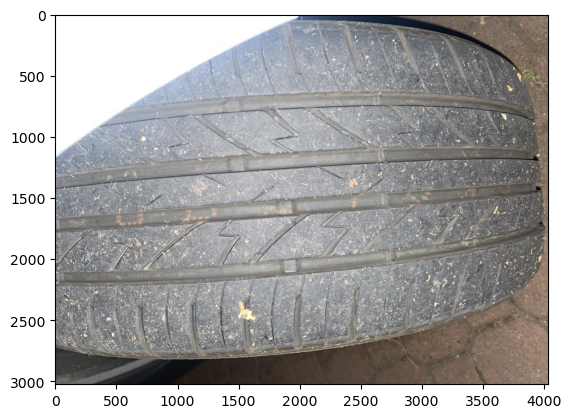

In [20]:
# Load the image and preprocess it
from PIL import Image

image = Image.open("./Test/4.JPG")
plt.imshow(image)
image_tensor = transform(image).unsqueeze(0).to(device)

In [21]:
with torch.no_grad():
    outputs = model(image_tensor)
    
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    predicted = torch.max(probabilities, 1)

class_labels = ['roadtire', 'offroad']

prediction = class_labels[predicted.indices.item()]

confidence = predicted.values.item()

print(f"The image is classified as: {prediction} with confidence: {confidence * 100}%")

The image is classified as: roadtire with confidence: 99.99531507492065%
